In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def calc_decision_boundary(weights):
    m = -weights[2] / weights[1]
    b = -weights[0]
    return np.array([m, b])

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# Gradient Descent

Let's start with an intuitive explanation. You're lost in the mountains with zero visibility and need to get back to the bottom. At each step, you can feel the grade of the slope beneath your feet. If the slope is descending, you continue forward, otherwise you change course.

We can visualize this with a simple mathematical sample.

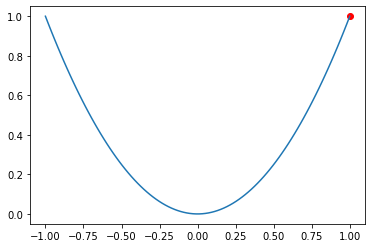

In [3]:
x = np.linspace(-1, 1, 100)
y = x**2

# loc depicts our current position
loc_x = 1.0
loc_y = loc_x**2

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.scatter(loc_x, loc_y, c='r')

Here we are at the top of the hill. How do determine the slope of a function $f$ at a given point $x$?

Good old calculus: $\frac{df}{dx}$. In this case $\frac{df}{dx} = 2x$

In [4]:
# loc depicts our current position
d_loc = 2 * loc_x
print("Derivative at x = {} is {}".format(loc_x, d_loc))

Derivative at x = 1.0 is 2.0


We have calculated that a x = 1, the slope (derivative) of the function is 2. Now to use this knowledge to step forward.

## Update Step

The all important update step is actually quite simple:

$$x_{n+1} = x_n - \frac{df}{dx}.$$

Let's apply this update step and check our position again.

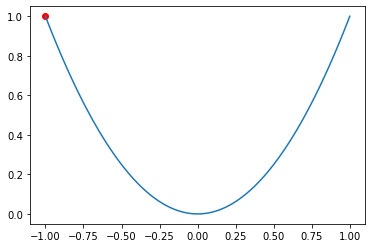

In [5]:
x_new = loc_x - d_loc
y_new = x_new ** 2

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.scatter(x_new, y_new, c='r')

Wow we took a really big step and ended up on the other side of the function. It seems we missed an important part of gradient descent: the **step size**. To control the step size, we add a single parameter to the update step:

$$x_{n+1} = x_n - \alpha * \frac{df}{dx}.$$

This new value $\alpha$ is a parameter that controls how big of a step we can take. In the context of machine learning, the step size is called the **learning rate**. Let's reduce this to 0.1 and see where it takes us.

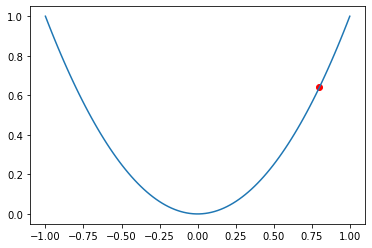

In [6]:
alpha = 0.1
x_new = loc_x - alpha * d_loc
y_new = x_new ** 2

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.scatter(x_new, y_new, c='r')

Next, let's use gradient descent to optimize our original linear classifier. Again, here is the data generated from our two distributions.

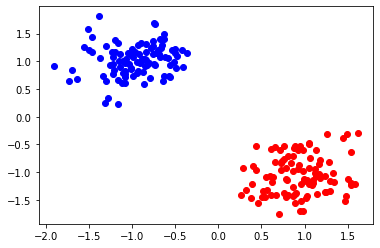

In [7]:
a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], 100)
b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], 100)
a_targets = np.zeros(100)  # Samples from class A are assigned a class value of 0.
b_targets = np.ones(100)  # Samples from class B are assigned a class value of 1.

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(a_samples[:, 0], a_samples[:, 1], c='b')
ax.scatter(b_samples[:, 0], b_samples[:, 1], c='r')

To set this up, we will **initialize** our network's parameters to be random values. We'll also introduce another neat trick. By including the bias in our parameter list, we can slightly simplify the forward calculation.

(-2.088421934285279,
 1.7991711678919102,
 -1.9319154848073274,
 1.992015319536714)

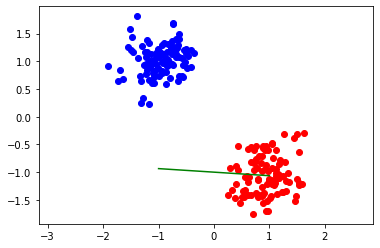

In [8]:
# Classifier Parameters
weights = np.random.rand(2) 
bias = 1
weights = np.concatenate(([bias], weights))

# For visualizing the line
m, b = calc_decision_boundary(weights)

# If the slope is undefined, it is vertical.
if weights[1] != 0:
    x = np.linspace(-1, 1, 100)
    y = m * x + b
else:
    x = np.zeros(100) + b
    y = np.linspace(-1, 1, 100)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, c='g')
ax.scatter(a_samples[:, 0], a_samples[:, 1], c='b')
ax.scatter(b_samples[:, 0], b_samples[:, 1], c='r')
plt.axis('equal')

If the bias is included in our weights vector, how do we compute the result? Concatenate a 1 to the input before multiplying.

In [9]:
# Linear combination of weights and input
y_a = weights @ np.concatenate((np.ones((100, 1)), a_samples), axis=-1).T
y_b = weights @ np.concatenate((np.ones((100, 1)), b_samples), axis=-1).T

# Sigmoid function
pred_a = sigmoid(y_a)
pred_b = sigmoid(y_b)

l2_a = 0.5 * ((a_targets - pred_a)**2)
l2_b = 0.5 * ((b_targets - pred_b)**2)
loss_a = l2_a.sum()
loss_b = l2_b.sum()
print("Loss A = {}".format(loss_a))
print("Loss B = {}".format(loss_b))

# Combine and normalize the error between 0 and 1.
loss = np.concatenate((l2_a, l2_b)).mean()
print("Normalized loss = {}".format(loss))

Loss A = 18.49866861466849
Loss B = 1.617504580940443
Normalized loss = 0.10058086597804466


So how do we use gradient descent to optimize our simple perceptron? First, note that we will be using the sigmoid function because it is **continuous**. This is a very important property when it comes to optimization because derivatives on discrete functions are undefined, although they can be approximated.

Our current classifier is a series of two functions followed by a loss function:

$$L(g(\mathbf{w}\mathbf{x}))$$

where $g(x) = \frac{1}{1 + \exp^{-x}}$

With each update of gradient descent we want to modify our parameters $\mathbf{w}$. So we need to calculate $\frac{\partial L}{\partial w_i}$. To find this gradient, we utilize the chain rule from Calculus which is:

$$\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}.$$

Applying this to our classifier, we have:

$$\frac{\partial L}{\partial w_i} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial a} \frac{\partial a}{\partial w_i}$$

Here we let $a = \sum_i w_i x_i$ so $\frac{\partial a}{\partial w_i} = x_i$ and $\frac{dy}{da} = g'(a) = g(a) * (1 - g(a))$.

The squared L2 loss function we are using is again defined as:

$$L = \frac{1}{2} (\hat{y} - y)^2$$

This is a convenient choice because the derivative is simple to calculate:

$$\frac{dL}{dy} = \hat{y} - y.$$

Written fully,

$$\frac{\partial L}{\partial w_i} = (\hat{y} - y) * g(a) * (1 - g(a)) * x_i.$$

In [10]:
# Combine our dataset into one single object
samples = np.concatenate((a_samples, b_samples))
targets = np.concatenate((a_targets, b_targets))
print(samples.shape)

(200, 2)


(1, 2)
Loss = [0.07922515]
[0.09537787] [-0.04699739]


(-2.088421934285279,
 1.7991711678919102,
 -1.9319154848073274,
 1.992015319536714)

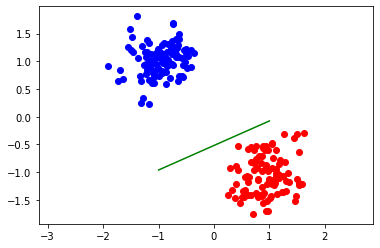

In [21]:
idx = np.random.randint(200, size=1)
alpha = 1
x = samples[idx]
y_hat = targets[idx]
print(x.shape)

# Linear combination of weights and input
a = weights @ np.concatenate((np.ones((1, 1)), x), axis=-1).T

# Sigmoid function
z = sigmoid(a)

loss = 0.5 * (z - y_hat)**2
print("Loss = {}".format(loss))

dw0 = (z - y_hat) * z * (1 - z)
dw1 = (z - y_hat) * z * (1 - z) * x[0, 0]
dw2 = (z - y_hat) * z * (1 - z) * x[0, 1]
print(dw0, dw1)
weights[0] = weights[0] - alpha * dw0
weights[1] = weights[1] - alpha * dw1
weights[2] = weights[2] - alpha * dw2

# for i in range(200):
#     idx = np.random.randint(200, size=1)
#     alpha = 1
#     x = samples[idx]
#     y_hat = targets[idx]

#     # Linear combination of weights and input
#     a = weights @ np.concatenate((np.ones((1, 1)), x), axis=-1).T

#     # Sigmoid function
#     z = sigmoid(a)

#     loss = 0.5 * (z - y_hat)**2

#     dw0 = (z - y_hat) * z * (1 - z)
#     dw1 = (z - y_hat) * z * (1 - z) * x[0, 0]
#     dw2 = (z - y_hat) * z * (1 - z) * x[0, 1]
#     weights[0] = weights[0] - alpha * dw0
#     weights[1] = weights[1] - alpha * dw1
#     weights[2] = weights[2] - alpha * dw2

# For visualizing the line
m, b = calc_decision_boundary(weights)

# If the slope is undefined, it is vertical.
if weights[1] != 0:
    x = np.linspace(-1, 1, 100)
    y = m * x + b
else:
    x = np.zeros(100) + b
    y = np.linspace(-1, 1, 100)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, c='g')
ax.scatter(a_samples[:, 0], a_samples[:, 1], c='b')
ax.scatter(b_samples[:, 0], b_samples[:, 1], c='r')
plt.axis('equal')